<a href="https://colab.research.google.com/github/RvsL/kaggle/blob/main/eruptions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

In [1]:
import pandas as pd
import numpy as np
import zipfile as zf
import os
import datetime as dt
from tqdm import tqdm, tqdm_notebook
import re
import string
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')


def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
def tstats(t, doplot = False):
    print('#'*20, get_df_name(t), t.shape)
    for _,i in enumerate(t):
        nulls = t[i].isna().sum()
        if nulls > 0:
            print(i,'=', t[i].nunique(), ',NULLS = ', nulls, ',% of nulls = ',round(100*nulls/t.shape[0]))
        else:
            print(i,'=', t[i].nunique())
    if doplot:
        print()
        print(t.sample(10))
        print()
        
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.cluster import KMeans


In [3]:
!pip install catboost

     |████████████████████████████████| 65.8MB 73kB/s 


In [4]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import gc

def plot_history(history, metricname):
    recall = history.history[metricname]
    val_recall = history.history['val_' + metricname]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(recall) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, recall, 'b', label='Training')
    plt.plot(x, val_recall, 'r', label='Validation')
    plt.title('Training and validation')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
from keras import regularizers as kreg
from keras.layers import Dense
from keras.models import Sequential

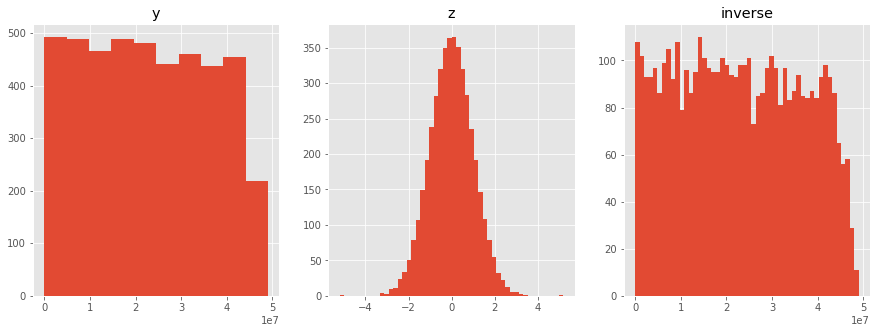

In [19]:
def prepare_data(scale=False):
    
    t4m = pd.read_csv('/content/drive/MyDrive/2 - рабочее/32 - PMI/random/t4m_10.csv')
    t4p = pd.read_csv('/content/drive/MyDrive/2 - рабочее/32 - PMI/random/t4p_10.csv')
    features = t4m.columns[1:-1]
    target = 'time_to_eruption'

    df = t4m[t4m.columns[1:]].copy()
    t = df.corr()[target].reset_index()
    t[target] = abs(t[target])
    t.sort_values(by=target, ascending = False)

    t = t.loc[(t[target] > 0.05)&(t[target] < 1)].sort_values(by=target, ascending=False).reset_index()

    good_features = t['index'].values

    scaler = StandardScaler()

    # for train
    t = pd.DataFrame(scaler.fit_transform(t4m[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4m['sum_feat'] = t['sum_feat'].values
    t4m['mul_feat'] = t['mul_feat'].values
    t4m['s_m_feat'] = t['s_m_feat'].values


    # for test
    t = pd.DataFrame(scaler.fit_transform(t4p[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4p['sum_feat'] = t['sum_feat'].values
    t4p['mul_feat'] = t['mul_feat'].values
    t4p['s_m_feat'] = t['s_m_feat'].values


    clfeat = ['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
          's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
          's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
          's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
          's08p_peak_y02', 's06p_peak_x00', 'sum_feat']    
    
    kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
    kmeans.fit(t4m[clfeat])
    t4m['cluster'] = kmeans.labels_
    t4p['cluster'] = kmeans.predict(t4p[clfeat])

    feat = list(features)
    feat.append('sum_feat')
    feat.append('mul_feat')
    feat.append('s_m_feat')
    feat.append('cluster')
    
    if scale:
      scaler = StandardScaler()
      t4m[feat] = scaler.fit_transform(t4m[feat])
      t4p[feat] = scaler.transform(t4p[feat])

    X, y = t4m[feat], t4m[target]

    data = y.values.reshape(-1, 1)

    from sklearn.preprocessing import QuantileTransformer

    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal',
                             random_state=rng)

    z = qt.fit_transform(data)
    z_back = qt.inverse_transform(z)

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(data)
    plt.title('y')

    plt.subplot(132)
    plt.hist(z, bins = 50)
    plt.title('z')

    plt.subplot(133)
    plt.hist(z_back, bins = 50)
    plt.title('inverse')

    plt.show()
    
    return t4m, t4p, X, y, z, feat, target, qt

t4m, t4p, X, y, z, feat, target, qt = prepare_data()

def de_qt(val):
    return qt.inverse_transform(val.reshape(-1, 1)).ravel()


Fold 0:
Training until validation scores don't improve for 50 rounds.
[200]	training's l1: 5.4294e+06	valid_1's l1: 6.57781e+06
[400]	training's l1: 2.80014e+06	valid_1's l1: 4.71789e+06
[600]	training's l1: 1.63451e+06	valid_1's l1: 4.05637e+06
[800]	training's l1: 1.05514e+06	valid_1's l1: 3.79842e+06
[1000]	training's l1: 726297	valid_1's l1: 3.69557e+06
[1200]	training's l1: 517345	valid_1's l1: 3.65401e+06
[1400]	training's l1: 375979	valid_1's l1: 3.63171e+06
[1600]	training's l1: 278064	valid_1's l1: 3.61869e+06
[1800]	training's l1: 209107	valid_1's l1: 3.60978e+06
[2000]	training's l1: 159382	valid_1's l1: 3.60454e+06
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 159382	valid_1's l1: 3.60454e+06
Fold 1:
Training until validation scores don't improve for 50 rounds.
[200]	training's l1: 5.46231e+06	valid_1's l1: 6.54017e+06
[400]	training's l1: 2.84874e+06	valid_1's l1: 4.73796e+06
[600]	training's l1: 1.66655e+06	valid_1's l1: 4.07909e+06
[800]	training'

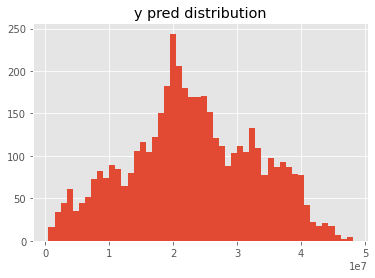

CPU times: user 14min 15s, sys: 2.91 s, total: 14min 18s
Wall time: 7min 15s


In [6]:
%%time

n_fold = 2
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "cpu",
}

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

# my_submission = pd.DataFrame({
#     'segment_id':t4p['segment_id'].values,
#     'time_to_eruption':y_pred
# })

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

# my_submission.to_csv(f'submission_{ver}.csv', index=False)

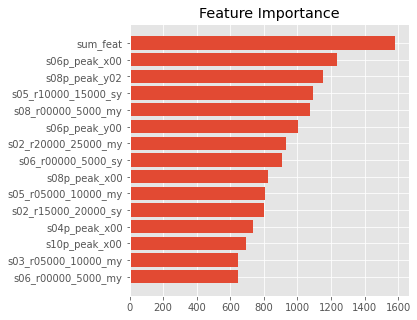

In [8]:
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = target)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[target])
plt.show()

In [10]:
t['feature'].values

array(['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
       's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
       's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
       's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
       's08p_peak_y02', 's06p_peak_x00', 'sum_feat'], dtype=object)


Number of clusters = 2
Silhouette score = 0.7138461719439304

Number of clusters = 3
Silhouette score = 0.824006564020425

Number of clusters = 4
Silhouette score = 0.8361216066019819

Number of clusters = 5
Silhouette score = 0.8503628312783316

Number of clusters = 6
Silhouette score = 0.8584602384295535

Number of clusters = 7
Silhouette score = 0.8625610020022525

Number of clusters = 8
Silhouette score = 0.8548783852113961

Number of clusters = 9
Silhouette score = 0.8637027566739169

Number of clusters = 10
Silhouette score = 0.8704919156450482

Number of clusters = 11
Silhouette score = 0.7802298863386561

Number of clusters = 12
Silhouette score = 0.78095378797104

Number of clusters = 13
Silhouette score = 0.7244596148543749

Number of clusters = 14
Silhouette score = 0.7687220953424873

Optimal number of clusters = 10


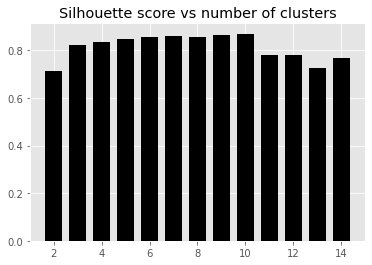

In [14]:
clfeat = ['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
       's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
       's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
       's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
       's08p_peak_y02', 's06p_peak_x00', 'sum_feat']

from sklearn import metrics
from sklearn.cluster import KMeans

# Initialize variables
scores = []
values = np.arange(2, 15)

X = t4m[clfeat].values
# Iterate through the defined range
for num_clusters in values:
    # Train the KMeans clustering model
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(X)
    score = metrics.silhouette_score(X, kmeans.labels_, 
                metric='euclidean', sample_size=len(X))

    print("\nNumber of clusters =", num_clusters)
    print("Silhouette score =", score)
                    
    scores.append(score)

# Plot silhouette scores
plt.figure()
plt.bar(values, scores, width=0.7, color='black', align='center')
plt.title('Silhouette score vs number of clusters')

# Extract best score and optimal number of clusters
num_clusters = np.argmax(scores) + values[0]
print('\nOptimal number of clusters =', num_clusters)

plt.show()

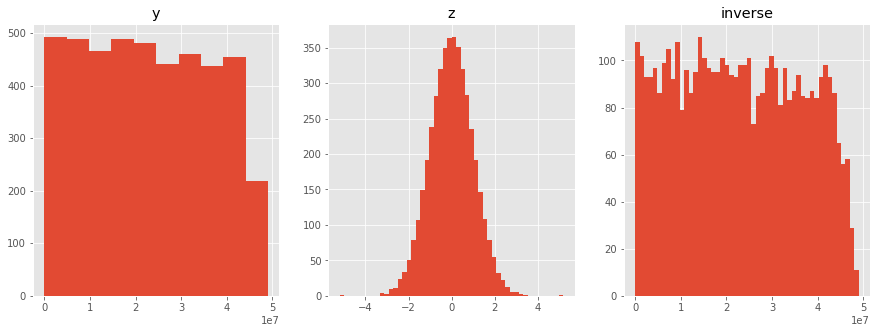

Fold 0:
Training until validation scores don't improve for 50 rounds.
[200]	training's l1: 5.5677e+06	valid_1's l1: 6.16994e+06
[400]	training's l1: 3.07151e+06	valid_1's l1: 4.27505e+06
[600]	training's l1: 1.97305e+06	valid_1's l1: 3.5806e+06
[800]	training's l1: 1.41777e+06	valid_1's l1: 3.31607e+06
[1000]	training's l1: 1.08108e+06	valid_1's l1: 3.1944e+06
[1200]	training's l1: 850666	valid_1's l1: 3.13976e+06
[1400]	training's l1: 677756	valid_1's l1: 3.1129e+06
[1600]	training's l1: 545894	valid_1's l1: 3.09779e+06
[1800]	training's l1: 441427	valid_1's l1: 3.08448e+06
[2000]	training's l1: 358349	valid_1's l1: 3.07543e+06
[2200]	training's l1: 292065	valid_1's l1: 3.069e+06
[2400]	training's l1: 238697	valid_1's l1: 3.06353e+06
[2600]	training's l1: 195918	valid_1's l1: 3.05985e+06
[2800]	training's l1: 161628	valid_1's l1: 3.05703e+06
[3000]	training's l1: 133803	valid_1's l1: 3.05486e+06
[3200]	training's l1: 111287	valid_1's l1: 3.05306e+06
[3400]	training's l1: 92691	valid_1

In [ ]:
%%time

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True)

ver = 36
n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "cpu",
}

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

my_submission = pd.DataFrame({
    'segment_id':t4p['segment_id'].values,
    'time_to_eruption':y_pred
})

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

my_submission[target] = abs(my_submission[target])

my_submission.to_csv(f'submission_{ver}.csv', index=False)